In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [27]:
# Define dataset path (Update this path as needed)
train_dir = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/workshop6/FruitinAmazon/train"

# List to store corrupted image paths
corrupted_images = []

# Iterate through class directories
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Try opening the image
                with Image.open(image_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, SyntaxError):
                # If the image is corrupted, remove it
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

# Print summary
if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [28]:
import os
import random

# Define your training directory path
train_dir = '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/workshop6/FruitinAmazon/train'

# Get the list of class names (subdirectories in train_dir)
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images: # Ensure the class folder is not empty
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

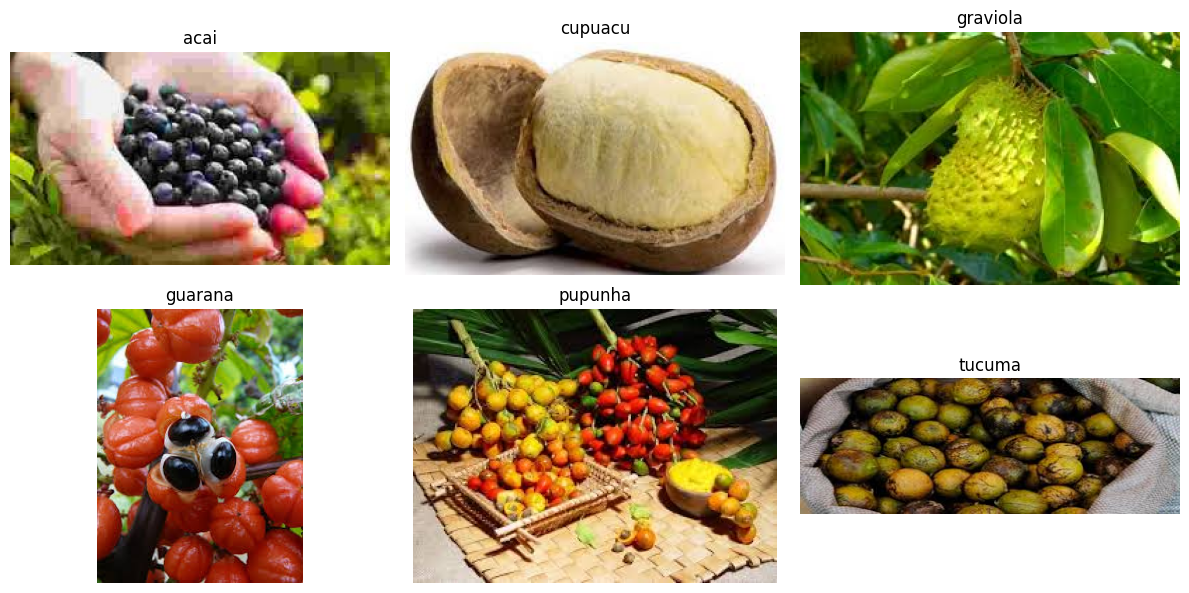

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
else:
  ax.axis("off") # Hide empty subplots
  plt.tight_layout()
  plt.show()

What did you Observe?

The dataset consists of unique images, with each one belonging to a distinct class, ensuring proper structural organization.
The images exhibit diversity in resolution, lighting conditions, and orientation.
Certain classes contain fewer samples, highlighting potential class imbalance.
Preprocessing steps such as resizing and normalization may be required to standardize the data.

In [30]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
  class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [31]:
import tensorflow as tf
from tensorflow.keras import layers
import os

# Set image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2
seed = 123

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)


train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [33]:
# Path to the test folder
test_dir = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/workshop6/FruitinAmazon/test"

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int",  # or "categorical" if you trained that way
    shuffle=False  # Important for consistent evaluation
)

# Prefetch test dataset for performance
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 30 files belonging to 6 classes.


In [34]:
# Data augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Rescale input images to [0, 1]
rescale = layers.Rescaling(1./255)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [36]:
from tensorflow.keras import models

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    rescale,

    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])


In [37]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,798 (32.08 MB)

 Trainable params: 8,409,350 (32.08 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2630 - loss: 2.2639 - val_accuracy: 0.1667 - val_loss: 2.7191
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6259 - loss: 1.1770 - val_accuracy: 0.2778 - val_loss: 1.9061
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5326 - loss: 1.3398 - val_accuracy: 0.1667 - val_loss: 1.6267
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6259 - loss: 0.9773 - val_accuracy: 0.1667 - val_loss: 1.7679
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5738 - loss: 1.1614 - val_accuracy: 0.1111 - val_loss: 1.9250
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6979 - loss: 0.9750 - val_accuracy: 0.1111 - val_loss: 2.0663
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7005 - loss: 0.8001 - val_accuracy: 0.1111 - val_loss: 2.1581
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6202 - loss: 0.8710 - val_accuracy: 0.1111 - val_loss: 2.2285
Epoch 9/25
3/3 ━

In [38]:
from collections import Counter
val_labels = []

for _, labels in val_ds.unbatch():
    val_labels.append(int(labels.numpy()))

print("Validation class distribution:", Counter(val_labels))


Validation class distribution: Counter({3: 5, 4: 4, 5: 3, 2: 3, 1: 2, 0: 1})


#Image classification using fine tuning with VGG16


In [39]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [40]:
# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [41]:
# Add your custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)


In [42]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',  # use sparse if labels are integers
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
img_height, img_width = 224, 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32,
    label_mode="int"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 15s/step - accuracy: 0.1115 - loss: 8.0667 - val_accuracy: 0.3889 - val_loss: 4.3335
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 15s/step - accuracy: 0.5951 - loss: 2.0855 - val_accuracy: 0.6667 - val_loss: 3.6841
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.7973 - loss: 0.8427 - val_accuracy: 0.6667 - val_loss: 2.9074
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.9635 - loss: 0.1195 - val_accuracy: 0.6111 - val_loss: 2.7157
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.9705 - loss: 0.0705 - val_accuracy: 0.5000 - val_loss: 3.7752
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.9635 - loss: 0.0810 - val_accuracy: 0.5000 - val_loss: 3.8511
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.9813 - loss: 0.0269 - val_accuracy: 0.5556 - val_loss: 3.3828
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 16s/step - accuracy: 1.0000 - loss: 8.8512e-04 - val_accuracy: 0.5556 - val_loss: 3.2

In [45]:
import numpy as np
from sklearn.metrics import classification_report

# Predict on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Generate report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
              precision    recall  f1-score   support

        acai       0.50      1.00      0.67         1
     cupuacu       0.33      0.50      0.40         2
    graviola       1.00      0.33      0.50         3
     guarana       0.57      0.80      0.67         5
     pupunha       0.50      0.25      0.33         4
      tucuma       0.67      0.67      0.67         3

    accuracy                           0.56        18
   macro avg       0.60      0.59      0.54        18
weighted avg       0.61      0.56      0.54        18

